In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [3]:
x_item_train = np.loadtxt('../../data/input_formated/withuser/x_item_train.csv')
x_user_train = np.loadtxt('../../data/input_formated/withuser/x_user_train.csv')
y_train = np.loadtxt('../../data/input_formated/withuser/y_train.csv').reshape((-1, 1))


In [4]:
x_item_test = np.loadtxt('../../data/input_formated/withuser/x_item_test.csv')
x_user_test = np.loadtxt('../../data/input_formated/withuser/x_user_test.csv')
y_test = np.loadtxt('../../data/input_formated/withuser/y_test.csv').reshape((-1, 1))


In [5]:
x_item_test = np.array(x_item_test, dtype = np.float32)
x_user_test = np.array(x_user_test, dtype = np.float32)
y_test = np.array(y_test, dtype = np.float32)

# ANN

In [6]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [7]:
class ANN_2input(nn.Module):
    def __init__(self, input_0_size, input_1_size, output_size):
        super(ANN_2input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, output_size) 
        self.fc1 = nn.Linear(input_1_size, output_size)  
        self.fc_out0 = nn.Linear(output_size, output_size)
        self.fc_out1 = nn.Linear(output_size, output_size)
        self.fc = nn.Linear(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x_0, x_1):
        h_0 = self.fc0(x_0)
        h_1 = self.fc1(x_1)
        h = self.activate(self.fc(self.fc_out0(h_0) + self.fc_out1(h_1)))
        return h

In [8]:
def train(x_0, x_1, y, learning_rate, num_epochs, check_point = 100):
    n = int(0.8 * len(y))
    x_0_train = np.array(x_0[:n, :], dtype = np.float32)
    x_0_val = np.array(x_0[n:, :], dtype = np.float32)
    x_1_train = np.array(x_1[:n, :], dtype = np.float32)
    x_1_val = np.array(x_1[n:, :], dtype = np.float32)
    
    y_train = np.array(y[:n, :], dtype = np.float32)
    y_val = np.array(y[n:, :], dtype = np.float32)

    model = ANN_2input(x_0_train.shape[1], x_1_train.shape[1], y_train.shape[1])

    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    train_loss_list, val_loss_list = [], []

    #early stopping
    max_patience = 100
    patience = 0
    best_val = None
    
    # Train the Model 
    for epoch in range(num_epochs):
        # Convert numpy array to torch Variable
        inputs_0 = Variable(torch.from_numpy(x_0_train))
        inputs_1 = Variable(torch.from_numpy(x_1_train))
        targets = Variable(torch.from_numpy(y_train), requires_grad = False)

        # Forward + Backward + Optimize
        optimizer.zero_grad()  
        outputs = model(inputs_0, inputs_1)
        train_loss = criterion(outputs, targets)
        
        train_loss_list.append(train_loss.data[0])

        #validate
        inputs_0 = Variable(torch.from_numpy(x_0_val))
        inputs_1 = Variable(torch.from_numpy(x_1_val))
        targets = Variable(torch.from_numpy(y_val), requires_grad = False)
        outputs = model(inputs_0,inputs_1)   
        val_loss = criterion(outputs, targets)
        val_loss_list.append(val_loss.data[0])
        

        train_loss.backward()
        optimizer.step()

        if (epoch == 0) or ((epoch+1) % check_point == 0):
            print ('Epoch [%d/%d], Loss: %.4f, %.4f' 
                   %(epoch+1, num_epochs, train_loss.data[0], val_loss.data[0]))
        if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
            best_val = val_loss
            patience = max_patience
        else:
            patience -= 1
        if patience == 0:
            print 'Early stopping at %d' % epoch
            break            

    #Plot the graph
    plt.plot(range(len(val_loss_list)), train_loss_list, label='train')
    plt.plot(range(len(val_loss_list)), val_loss_list, label ='validate')
    
    plt.legend()
    plt.show()
    
    return model

Epoch [1/500], Loss: 0.0544, 0.0541
Epoch [100/500], Loss: 0.0480, 0.0478
Epoch [200/500], Loss: 0.0480, 0.0478
Epoch [300/500], Loss: 0.0480, 0.0478
Epoch [400/500], Loss: 0.0480, 0.0478
Epoch [500/500], Loss: 0.0480, 0.0478


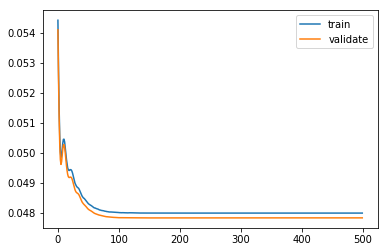

In [9]:
model = train(x_item_train, x_user_train, y_train, learning_rate = 0.01, num_epochs= 500, check_point = 100)

In [10]:
inputs_0 = Variable(torch.from_numpy(x_item_test))
inputs_1 = Variable(torch.from_numpy(x_user_test))
targets = Variable(torch.from_numpy(y_test[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0908
[torch.FloatTensor of size 1]



Epoch [1/5000], Loss: 0.0520, 0.0518
Epoch [100/5000], Loss: 0.0480, 0.0478
Epoch [200/5000], Loss: 0.0480, 0.0478
Epoch [300/5000], Loss: 0.0480, 0.0478
Epoch [400/5000], Loss: 0.0480, 0.0478
Epoch [500/5000], Loss: 0.0480, 0.0478
Epoch [600/5000], Loss: 0.0480, 0.0478
Epoch [700/5000], Loss: 0.0480, 0.0478
Epoch [800/5000], Loss: 0.0480, 0.0478
Epoch [900/5000], Loss: 0.0480, 0.0478
Epoch [1000/5000], Loss: 0.0480, 0.0478
Epoch [1100/5000], Loss: 0.0480, 0.0478
Epoch [1200/5000], Loss: 0.0480, 0.0478
Epoch [1300/5000], Loss: 0.0480, 0.0479
Epoch [1400/5000], Loss: 0.0480, 0.0478
Epoch [1500/5000], Loss: 0.0480, 0.0478
Epoch [1600/5000], Loss: 0.0480, 0.0478
Epoch [1700/5000], Loss: 0.0480, 0.0478
Epoch [1800/5000], Loss: 0.0480, 0.0478
Epoch [1900/5000], Loss: 0.0480, 0.0478
Epoch [2000/5000], Loss: 0.0480, 0.0478
Epoch [2100/5000], Loss: 0.0480, 0.0478
Epoch [2200/5000], Loss: 0.0480, 0.0478
Epoch [2300/5000], Loss: 0.0480, 0.0478
Epoch [2400/5000], Loss: 0.0480, 0.0478
Epoch [2500/

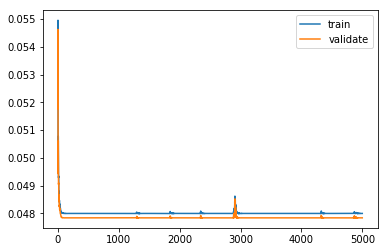

In [13]:
model = train(x_item_train, x_user_train, y_train, learning_rate = 0.1, num_epochs= 5000, check_point = 100)

In [12]:
inputs_0 = Variable(torch.from_numpy(x_item_test))
inputs_1 = Variable(torch.from_numpy(x_user_test))
targets = Variable(torch.from_numpy(y_test[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs_0, inputs_1).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0908
[torch.FloatTensor of size 1]

